In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [1]:

from argparse import ArgumentParser
from collections import defaultdict
from math import ceil, sin
from math import floor

import scipy
import pandas as pd
import numpy as np

import numpy as np
import torch

#import torch_xla
#import torch_xla.core.xla_model as xm
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd.functional import jacobian
from torch.nn.modules.container import T

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib as mpl
from functools import partial

In [2]:
from scipy.interpolate import griddata

In [22]:
from matplotlib.gridspec import GridSpec

Run this notebook with cuda

In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=8124fba9e2eba378f67781942a7ca05d2bb3fec4753f43df56345f60b256560b
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=xm.xla_device()

In [5]:
device

device(type='cuda')

In [6]:
from pyDOE import lhs

In [7]:
#v = torch.tensor(1.0/torch.pi**2)  # Viscosity coefficient
v = (0.01/torch.pi)  # From Raissi article


hidden_dim = 50
hidden_layers = 6
input_dim=2
output_dim=1
lambda_f=1
resblocks=0 # 0 when not Resnet
activation='tanh'
learningRate=0.0001
wd=1e-5      # 1e-5 er bedst
n_epochs=6000
N=2000
N_f=1000
N_u=2000
network='MLP' # Or Resnet, DeepOnet

In [ ]:

wandb.init(
    # set the wandb project where this run will be logged
    project="Burgesfinal",

    # track hyperparameters and run metadata
    config={
    "Viscosity": v,
    "N_f":N_f,
    "N_u":N_u,
    "learning_rate": learningRate,
    "weight_decay": wd,
    "hidden_layers": hidden_layers,
    "hidden_dim": hidden_dim,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation':activation,
    'lambda': lambda_f,
    'numResblocks': resblocks,
    "epochs": n_epochs,
    'network': network
    }
)

In [8]:
# function to plot the three loss terms initial/boundary condition and residual
def plot_loss(losses):
    fig, ax = plt.subplots()
    fig.canvas.manager.set_window_title("Loss terms")

    # Extract the loss values from the dictionary
    lossNN = losses["Res"]
    lossBC = losses["BC"]
    lossIC=losses['IC']
    #lossData=losses["Data"]
    # Plot both losses
    ax.plot(lossNN, label='Residual')
    ax.plot(lossBC, label='BC')
    ax.plot(lossIC, label='IC')
    #ax.plot(lossData, label='Data')

    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Neural Network and Equation Losses over Epochs")
    plt.show()


In [9]:
losses = defaultdict(list)

In [12]:
# Xavier initialization
def xavier_init(module):
        for m in module.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)


In [13]:
# Sinusoidal activation function
class SinusActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

In [14]:
# MLP Neural network as a function of the number of neurons, layers and the activation function

def construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation):
    # Activation function mapping
    activations = {
        'swish': nn.SiLU,
        'tanh': nn.Tanh,
        'relu': nn.ReLU,
        'gelu': nn.GELU,
        'softplus': nn.Softplus,
        'sin': SinusActivation
    }

    # Check if activation is valid
    if activation not in activations:
        raise ValueError(f"Invalid activation function. Expected one of: {list(activations.keys())}")

    ActivationFunc = activations[activation]

    # Construct the layers
    layers = [nn.Linear(input_dim, hidden_dim), ActivationFunc()]
    for _ in range(hidden_layers):
        layers.extend([nn.Linear(hidden_dim, hidden_dim), ActivationFunc()])
    layers.append(nn.Linear(hidden_dim, output_dim))
    layers.append(ActivationFunc())  # Activation function for the output layer


    # Create the network
    net = nn.Sequential(*layers).double().to(device)

    xavier_init(net)
    return net

# Example usage:
# net = construct_network(10, 2, 128, 3, 'relu', device='cuda')


In [15]:
# Add the two new learnable parameters to the network
class PINN(nn.Module):
    def __init__(self, base_network):
        super(PINN, self).__init__()
        self.network = base_network
        self.nu = nn.Parameter(torch.tensor([-6.0], dtype=torch.float64))  # Initialize nu as a learnable parameter
        self.phi=nn.Parameter(torch.tensor([0.5], dtype=torch.float64))
    def forward(self, x):
        return self.network(x)

In [16]:
# Model parameters

# Set random seed for reproducibility
torch.manual_seed(54)

# Interior conditions
#x_int = torch.rand(N, 2)  # [t; x], both in [0, 1]


x_int = lhs(2, N_f)  # [t; x], both in [0, 1]
#x_int=torch.rand(N_f,2)
x_int=torch.tensor(x_int)
x_int[..., 1] = 2 * (x_int[..., 1] - 0.5)  # shift x to [-1, 1]
#x_int_1=x_int[..., 1]
u_int = torch.zeros(N_f, 1) # original
u_train=-torch.exp(-x_int[...,0]) * torch.sin(torch.pi * x_int[...,1])


# Initial conditions
x_ini = torch.rand(N_u, 2)
x_ini[..., 0] = 0  # t = 0
x_ini[..., 1] = 2 * (x_ini[..., 1] - 0.5)  # x, -1 to 1
u_ini = torch.sin(-torch.pi * x_ini[..., 1]).reshape(N_u, 1)


# Boundary conditions
x_bc = torch.rand(N_u, 2)  # t, 0 to 1
x_bc[..., 1] = torch.tensor([-1, 1])[torch.randint(0, 2, (N_u,))]  # -1 or 1
u_bc = torch.zeros(N_u, 1)


# Merge inputs
#x_inp = torch.cat([x_int,x_bc, x_ini], dim=0).float()
x_inp = torch.cat([x_int, x_bc, x_ini], dim=0).float()

u_inp = torch.cat([u_int, u_bc, u_ini], dim=0).float()
#u_inp = torch.cat([u_bc, u_ini], dim=0).float()


# Print shapes to verify
print(f"x_inp shape: {x_inp.shape}, u_inp shape: {u_inp.shape}")
x_bc_inp = x_bc
x_ini_inp = x_ini
#x_inp = x_int
u_bc_inp = u_bc
u_ini_inp = u_ini
#u_inp = u_int

x_inp = torch.reshape(x_inp,(-1,2));
u_inp = torch.reshape(u_inp,(-1,1));

x_bc_inp = torch.reshape(x_bc_inp,(-1,2));
u_bc_inp = torch.reshape(u_bc_inp,(-1,1));

x_ini_inp = torch.reshape(x_ini_inp,(-1,2));
u_ini_inp = torch.reshape(u_ini_inp,(-1,1));





x_inp shape: torch.Size([5000, 2]), u_inp shape: torch.Size([5000, 1])


In [17]:
data = scipy.io.loadmat('/content/sample_data/burgers_shock.mat')

In [18]:
#data = scipy.io.loadmat('/content/sample_data/burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)


In [19]:
X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None]))
u_star = Exact.flatten()[:,None]


In [20]:
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = torch.tensor(X_star[idx,:]).requires_grad_(True)
u_train = torch.tensor(u_star[idx,:])

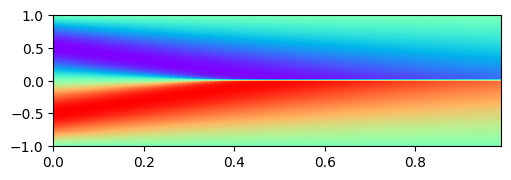

In [23]:
 ####### Row 0: u(t,x) ##################
gs0 = GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
  #divider = make_axes_locatable(ax)
  #cax = divider.append_axes("right", size="5%", pad=0.05)
  #fig.colorbar(h, cax=cax)

In [24]:
def data_loss(xint,u_obs):
  u_pred=model(xint.double().to(device))
  #print(u_obs.shape)
  return torch.mean((u_pred.flatten()-u_obs.double().to(device).flatten())**2)

In [25]:
def loss_initial(xinit,uinit):
  # Predictions for initial
  u_ini_pred = model(xinit.double().to(device))
  # Initial loss
  return torch.mean((u_ini_pred.flatten() - uinit.double().to(device).flatten())**2)

In [26]:
def loss_boundary(xbc,ubc):
  # Predictions for boundary conditions
  u_bc_pred = model(xbc.double().to(device))
  # Loss for boundary conditions
  return torch.mean((u_bc_pred.flatten() - ubc.double().to(device).flatten())**2)

In [27]:
def loss_residual(xint):
  # interior points
  # Compute gradients for the Burger's Equation
  xint.requires_grad_(True)
  # Model prediction
  u = model(xint.double().to(device))
  # Gradients of u with respect to x
  u_x = torch.autograd.grad(u, xint, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  # Components of the gradient
  u_t = u_x[:, 0]
  u_x = u_x[:, 1]

  # Second derivative with respect to x
  u_xx = torch.autograd.grad(u_x, xint, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1]
  # Burger's Equation Residual
  f = u_t.to(device) + (model.phi.to(device)*u.flatten() * u_x.to(device)) - (torch.exp(model.nu).to(device) * u_xx.to(device))
  # Return interior loss
  return torch.mean(f**2)


In [28]:
 # Initialize the model
#model = PINN()
#model = PhysicsInformedNet().double().to(device)
base_network = construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation)
model = PINN(base_network).double().to(device)
#model=construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation)

#model = SimpleResNetScalar(num_classes=output_dim, features=hidden_dim, num_blocks=resblocks).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=wd)



In [29]:
print(model)

PINN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Tanh()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): Tanh()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Tanh()
    (14): Linear(in_features=50, out_features=1, bias=True)
    (15): Tanh()
  )
)


In [30]:
losses={}
losses["Res"] = []
losses["BC"] = []
losses["IC"]=[]
#losses["Data"]=[]
flag_data=True
total_loss = []
   # Train Model
for epoch in range(n_epochs):
  optimizer.zero_grad()
  #loss_ini=loss_initial(x_ini_inp,u_ini_inp)
  #loss_bc=loss_boundary(x_bc_inp,u_bc_inp)
  #loss_res=loss_residual(x_inp)
  loss_res=loss_residual(X_u_train)
  loss_data=data_loss(X_u_train, u_train)
  #print(loss_data.shape)
  total_loss = lambda_f*(loss_res)+loss_data
  #+loss_bc+loss_ini
  #+flag_data*(loss_data)
  #total_loss = loss_bc+loss_ini+loss_data

  # Backward pass
  total_loss.backward()
  optimizer.step()

  losses['Res'].append(loss_res.item())
  #losses['BC'].append(loss_bc.item())
  #losses['IC'].append(loss_ini.item())
  #losses['Data'].append(loss_data.item())

  # Report History
  #wandb.log({"lossRES": loss_res.item(),
  #                     "lossInitial ": loss_ini.item(),
  #                     "LossBoundary": loss_bc.item(),
  #                      "LossTotal": total_loss.item()})

  if epoch % 100 == 0:
       print(f'Epoch {epoch}, Loss: {total_loss.item()}, Nu: {model.nu.item()}, lambda1: {model.phi.item()}')



Epoch 0, Loss: 0.6038032821670071, Nu: -5.999900010476064, lambda1: 0.4999000000697718
Epoch 100, Loss: 0.24718874620485826, Nu: -5.98747353653494, lambda1: 0.48834745786551326
Epoch 200, Loss: 0.23479857551783354, Nu: -5.975212314653836, lambda1: 0.47731974143905587
Epoch 300, Loss: 0.19969974719237277, Nu: -5.963460642055191, lambda1: 0.46977477484720875
Epoch 400, Loss: 0.10296758834724197, Nu: -5.937854343793857, lambda1: 0.45636218941282225
Epoch 500, Loss: 0.08033275558828525, Nu: -5.910410277377186, lambda1: 0.4332181489465365
Epoch 600, Loss: 0.0692988878571513, Nu: -5.891934143446762, lambda1: 0.4160393834221168
Epoch 700, Loss: 0.05918661597930156, Nu: -5.876210423340016, lambda1: 0.40172718010650454
Epoch 800, Loss: 0.050407692267492185, Nu: -5.861152820375677, lambda1: 0.3891047501747533
Epoch 900, Loss: 0.04330580502899058, Nu: -5.845780966262319, lambda1: 0.37746371103380627
Epoch 1000, Loss: 0.03668020494689893, Nu: -5.829202710108023, lambda1: 0.3662928798411854
Epoch 1

In [31]:
print('Truth',v)
estimate_nu=np.exp(model.nu.item())
print('Estimated v',estimate_nu)
print('Estimated lambda1',model.phi.item())
print('% error',np.abs(  (estimate_nu-v)/v  )*100   )
print('% error', np.abs(model.phi.item()-1.0)*100     )

Truth 0.003183098861837907
Estimated v 0.002930860842286387
Estimated lambda1 0.6233056427794699
% error 7.924291091790946
% error 37.66943572205301
